In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import joblib

# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon


def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))

    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
        bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                            multi_class='ovr', average='macro'))

    return np.median(bootstrap_aucs), bootstrap_aucs


def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:]
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (best_idx, second_best_idx)


def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val


def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex


targets = ['macula', 'optic_disc', 'vessels',  # abnormalities
           'diabetic_retinopathy', 'amd', 'macular_edema',  # retinal disease
           'quality',  # technical
           'insuline', 'diabetes']  # systemic

df = pd.read_csv('/mnt/c/Users/Justin/Desktop/labels.csv')
train_ids, test_ids = joblib.load('brset_train_test_split.pkl')
train_mask = df.patient_id.isin(train_ids).values
dftrain = df[train_mask]
dftest = df[~train_mask]

name_X_list = [
    ('RETFound-MEH', '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy'),
    ('DERETFound', '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 'X_ours_brset.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']


In [2]:
def run_brset_exp(name_X_list, models, colors,
                  figsize=(12, 4), dashed_line_offsets=(-2.75, 0.25), xtick_loc_scaling=1):
    targets = ['macula', 'optic_disc', 'vessels',  # abnormalities
               'diabetic_retinopathy', 'amd', 'macular_edema',  # retinal disease
               'quality',  # technical
               'insuline', 'diabetes']  # systemic

    results_df = pd.DataFrame(columns=['Name'] + targets)
    name_bootstrap_aucs_dict = {}
    name_times_dict = {}
    for name, Xfname in tqdm(name_X_list):
        np.random.seed(42)

        name_times_dict[name] = []
        median_aucs = []

        X = np.load(Xfname)
        X_train = X[train_mask]
        X_test = X[~train_mask]

        perf_str = f'{name:>20}:'
        for target_col in tqdm(targets, leave=True):
            y_train = dftrain[target_col].values
            y_test = dftest[target_col].values

            if target_col == 'optic_disc':
                # replace 'bv' with np.nan
                y_train = np.where(y_train == 'bv', np.nan, y_train)
                y_test = np.where(y_test == 'bv', np.nan, y_test)
            elif target_col == 'quality':
                # replace 'Adequate' with 0 and 'Inadequate' with 1
                y_train = np.array([dict(Adequate=0, Inadequate=1)[x] for x in y_train])
                y_test = np.array([dict(Adequate=0, Inadequate=1)[x] for x in y_test])

            train_non_missing_mask = pd.notnull(y_train)
            test_non_missing_mask = pd.notnull(y_test)

            y_train = y_train[train_non_missing_mask]
            X_train_current = X_train[train_non_missing_mask]

            y_test = y_test[test_non_missing_mask]
            X_test_current = X_test[test_non_missing_mask]

            if y_train[0] in ['yes', 'no']:
                y_train = np.array([dict(yes=1, no=0)[x] for x in y_train])
                y_test = np.array([dict(yes=1, no=0)[x] for x in y_test])

            y_train = y_train.astype(int)
            y_test = y_test.astype(int)

            if y_train.max() == 2 or y_test.max() == 2:
                y_train = y_train - 1
                y_test = y_test - 1

            start = time.time()
            clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
            clf.fit(X_train_current, y_train)
            preds = clf.predict_proba(X_test_current)[:, 1]
            stop = time.time()
            delta = stop - start
            name_times_dict[name].append(delta)

            curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
            name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
            median_aucs.append(curr_median_auc)

        perf_str += '\t'.join([f'{c}:{v:.4f}' for c, v in zip(targets, median_aucs)])
        print(perf_str)
        print(f'Total time: {sum(name_times_dict[name]):.4f}s / mean time: {np.mean(name_times_dict[name]):.4f}s')

        results_df.loc[name] = [name] + median_aucs

    display(results_df.round(4))

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes = axes.flat

    width = 0.25

    target_groups = {
        'Abnormalities of retinal landmarks': ['macula', 'optic_disc', 'vessels', ],
        'Retinal disease detection': ['diabetic_retinopathy', 'amd', 'macular_edema', ],
        'Non-retinal disease tasks': ['quality', 'insuline', 'diabetes', ],
    }

    wins = {_: 0 for _ in models}
    ties = {_: 0 for _ in models}

    for target_group, ax in zip(target_groups, axes):
        targets = target_groups[target_group]
        x = np.arange(len(targets))

        for i, model in enumerate(models):
            values = [results_df.loc[model, target] for target in targets]
            locs = x + i * width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] + dashed_line_offsets[0] * width
                    _right = locs[_idx] + dashed_line_offsets[1] * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [name_bootstrap_aucs_dict[f'{name}-{target}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()

            if p_val < 0.05:
                wins[models[best_idx]] += 1
            else:
                ties[models[best_idx]] += 1
                ties[models[second_best_idx]] += 1

            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val + 0.001, best_val + 0.012, best_val + 0.012, best_val + 0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val < 0.0001 else 0.01
            ax.text((start_loc + end_loc) / 2, best_val + text_loc_height_offset, pval_to_str(p_val), ha='center',
                    fontsize='x-small',
                    weight=None if not p_val < 0.05 else 'bold')

            ax.set_xticks(x + width * xtick_loc_scaling)
            targets_display = [_.replace('_', ' ').title().replace('Insuline', 'Insulin') for _ in targets]
            targets_display = [_.replace('Amd', "AMD").replace('Diabetic Retinopathy', 'DR').replace('Macular', 'Mac.')
                               for _ in targets_display]
            ax.set_xticklabels(targets_display, rotation=0, ha='center')
            ax.set_ylim(0.5, 1.03)
            ax.set_title(target_group)

    axes[0].set_ylabel('AUC on test set')
    axes[1].set_yticklabels([])
    axes[2].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    print('Statistically significant wins: ', wins)
    print('Ties for first place: ', ties)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

        RETFound-MEH:macula:0.8442	optic_disc:0.8487	vessels:0.7990	diabetic_retinopathy:0.9205	amd:0.9079	macular_edema:0.9201	quality:0.8784	insuline:0.7959	diabetes:0.8575
Total time: 19.4282s / mean time: 2.1587s


  0%|          | 0/9 [00:00<?, ?it/s]

          DERETFound:macula:0.8551	optic_disc:0.8873	vessels:0.7924	diabetic_retinopathy:0.9379	amd:0.9155	macular_edema:0.9382	quality:0.8962	insuline:0.8671	diabetes:0.8624
Total time: 19.0831s / mean time: 2.1203s


  0%|          | 0/9 [00:00<?, ?it/s]

      RETFound-Green:macula:0.8922	optic_disc:0.8561	vessels:0.8296	diabetic_retinopathy:0.9624	amd:0.9482	macular_edema:0.9751	quality:0.8855	insuline:0.8306	diabetes:0.8503
Total time: 5.8532s / mean time: 0.6504s


,Name,macula,optic_disc,vessels,diabetic_retinopathy,amd,macular_edema,quality,insuline,diabetes
RETFound-MEH,RETFound-MEH,0.8442,0.8487,0.7990,0.9205,0.9079,0.9201,0.8784,0.7959,0.8575
DERETFound,DERETFound,0.8551,0.8873,0.7924,0.9379,0.9155,0.9382,0.8962,0.8671,0.8624
RETFound-Green,RETFound-Green,0.8922,0.8561,0.8296,0.9624,0.9482,0.9751,0.8855,0.8306,0.8503


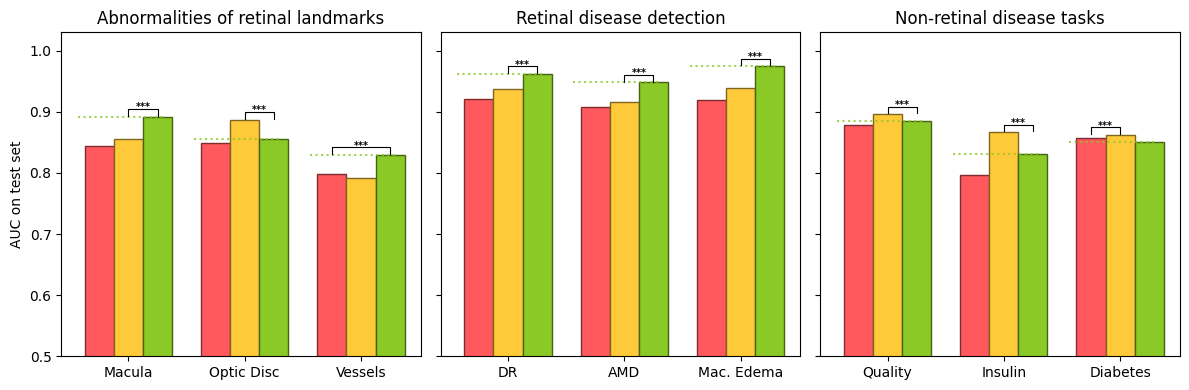

Statistically significant wins:  {'RETFound-MEH': 0, 'DERETFound': 4, 'RETFound-Green': 5}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 0, 'RETFound-Green': 0}


In [3]:
run_brset_exp(name_X_list, models, colors)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

      RETFound-Green:macula:0.8922	optic_disc:0.8561	vessels:0.8296	diabetic_retinopathy:0.9624	amd:0.9482	macular_edema:0.9751	quality:0.8855	insuline:0.8306	diabetes:0.8503
Total time: 5.4951s / mean time: 0.6106s


  0%|          | 0/9 [00:00<?, ?it/s]

              DinoV2:macula:0.8852	optic_disc:0.8340	vessels:0.8314	diabetic_retinopathy:0.9416	amd:0.9332	macular_edema:0.9692	quality:0.8761	insuline:0.8274	diabetes:0.8549
Total time: 6.1372s / mean time: 0.6819s


,Name,macula,optic_disc,vessels,diabetic_retinopathy,amd,macular_edema,quality,insuline,diabetes
RETFound-Green,RETFound-Green,0.8922,0.8561,0.8296,0.9624,0.9482,0.9751,0.8855,0.8306,0.8503
DinoV2,DinoV2,0.8852,0.8340,0.8314,0.9416,0.9332,0.9692,0.8761,0.8274,0.8549


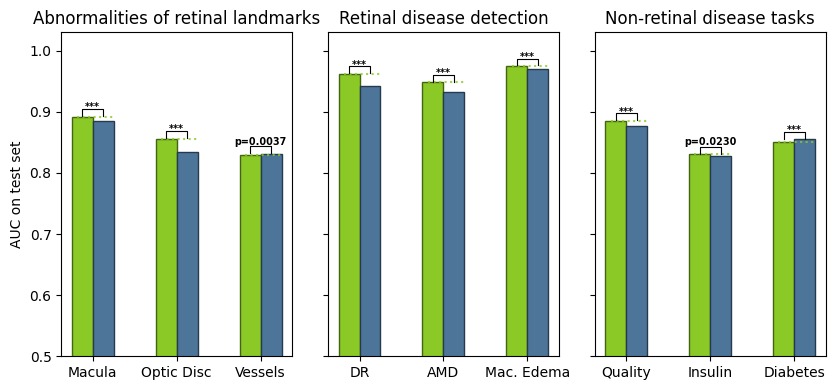

Statistically significant wins:  {'RETFound-Green': 7, 'DinoV2': 2}
Ties for first place:  {'RETFound-Green': 0, 'DinoV2': 0}


In [4]:
name_X_list = [
    ('RETFound-Green', 'X_ours_brset.npy'),
    ('DinoV2', 'X_ViTSDinov2_brset.npy'),
]

models = ['RETFound-Green', 'DinoV2']
colors = ['#8ac926', '#4d759a']

run_brset_exp(name_X_list, models, colors,
              figsize=(8.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

        RETFound-MEH:macula:0.8442	optic_disc:0.8487	vessels:0.7990	diabetic_retinopathy:0.9205	amd:0.9079	macular_edema:0.9201	quality:0.8784	insuline:0.7959	diabetes:0.8575
Total time: 21.9130s / mean time: 2.4348s


  0%|          | 0/9 [00:00<?, ?it/s]

          DERETFound:macula:0.8551	optic_disc:0.8873	vessels:0.7924	diabetic_retinopathy:0.9379	amd:0.9155	macular_edema:0.9382	quality:0.8962	insuline:0.8671	diabetes:0.8624
Total time: 18.4859s / mean time: 2.0540s


  0%|          | 0/9 [00:00<?, ?it/s]

  RETFound-Green@224:macula:0.8686	optic_disc:0.8448	vessels:0.8249	diabetic_retinopathy:0.9307	amd:0.9473	macular_edema:0.9644	quality:0.8832	insuline:0.8146	diabetes:0.8449
Total time: 6.9400s / mean time: 0.7711s


,Name,macula,optic_disc,vessels,diabetic_retinopathy,amd,macular_edema,quality,insuline,diabetes
RETFound-MEH,RETFound-MEH,0.8442,0.8487,0.7990,0.9205,0.9079,0.9201,0.8784,0.7959,0.8575
DERETFound,DERETFound,0.8551,0.8873,0.7924,0.9379,0.9155,0.9382,0.8962,0.8671,0.8624
RETFound-Green@224,RETFound-Green@224,0.8686,0.8448,0.8249,0.9307,0.9473,0.9644,0.8832,0.8146,0.8449


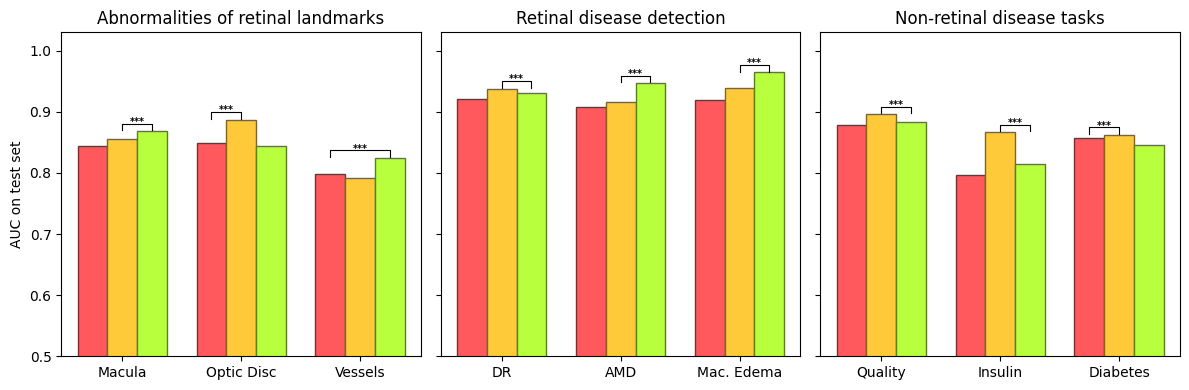

Statistically significant wins:  {'RETFound-MEH': 0, 'DERETFound': 5, 'RETFound-Green@224': 4}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 0, 'RETFound-Green@224': 0}


In [5]:
name_X_list = [
    ('RETFound-MEH', '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy'),
    ('DERETFound', '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy'),
    ('RETFound-Green@224', 'X_ours_brset_224.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green@224']
colors = ['#ff595e', '#ffca3a', '#B8FF3D']

run_brset_exp(name_X_list, models, colors)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  RETFound-Green@224:macula:0.8686	optic_disc:0.8448	vessels:0.8249	diabetic_retinopathy:0.9307	amd:0.9473	macular_edema:0.9644	quality:0.8832	insuline:0.8146	diabetes:0.8449
Total time: 7.5828s / mean time: 0.8425s


  0%|          | 0/9 [00:00<?, ?it/s]

          DinoV2@224:macula:0.8699	optic_disc:0.8201	vessels:0.8187	diabetic_retinopathy:0.9240	amd:0.9377	macular_edema:0.9575	quality:0.8778	insuline:0.8247	diabetes:0.8407
Total time: 6.9053s / mean time: 0.7673s


,Name,macula,optic_disc,vessels,diabetic_retinopathy,amd,macular_edema,quality,insuline,diabetes
RETFound-Green@224,RETFound-Green@224,0.8686,0.8448,0.8249,0.9307,0.9473,0.9644,0.8832,0.8146,0.8449
DinoV2@224,DinoV2@224,0.8699,0.8201,0.8187,0.9240,0.9377,0.9575,0.8778,0.8247,0.8407


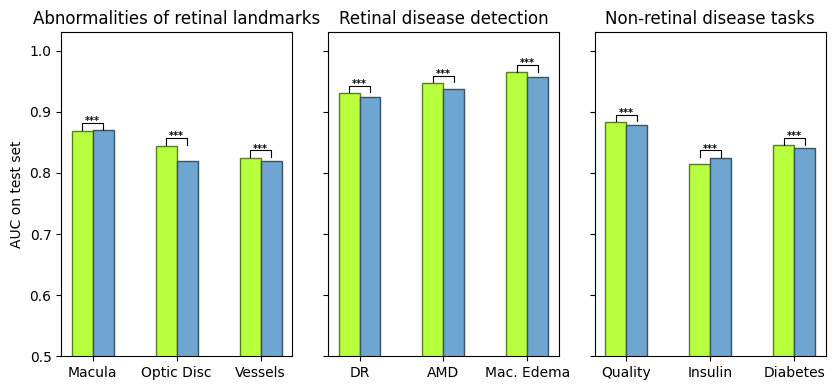

Statistically significant wins:  {'RETFound-Green@224': 7, 'DinoV2@224': 2}
Ties for first place:  {'RETFound-Green@224': 0, 'DinoV2@224': 0}


In [6]:
name_X_list = [
    ('RETFound-Green@224', 'X_ours_brset_224.npy'),
    ('DinoV2@224', 'X_original_dinov2_224_brset.npy'),
]


models = ['RETFound-Green@224', 'DinoV2@224']
colors = ['#B8FF3D', '#6EA6D1']

run_brset_exp(name_X_list, models, colors,
              figsize=(8.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5)